# Make Network File

In this notebook, we compile the seismic network metadata that will be used recurrently through the workflow. We also scan the whole preprocessed data set to measure the daily data availability, which is essential for estimating the detection capability of the network at a given time.

In [1]:
import fnmatch
import glob
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import obspy as obs

from BPMF.config import cfg
from BPMF.dataset import Network
from matplotlib.ticker import FixedLocator, FormatStrFormatter

In [2]:
NETWORK_FILENAME = "network.csv"
AVAILABILITY_FILENAME = "availability.csv"
preproc_folder_name = f"preprocessed_{cfg.MIN_FREQ_HZ:.0f}_{cfg.MAX_FREQ_HZ:.0f}"

In [3]:
# we check the station metadata and data availability between START_DATE and END_DATE
# these also define the start and end of the experiment
START_DATE = "2012-07-26"
END_DATE = "2012-07-26"
datelist = pd.date_range(start=START_DATE, end=END_DATE)
datelist

DatetimeIndex(['2012-07-26'], dtype='datetime64[ns]', freq='D')

In [4]:
# initialize data frames
daily_availability = pd.DataFrame()
network_metadata = pd.DataFrame(
    columns=["network_code", "station_code", "longitude", "latitude", "elevation_m"]
)

In [5]:
# even though this tutorial analyzes a single day, this notebook is written for an extended
# data base following the folder tree convention used here
for date in datelist:
    row_name = date.strftime("%Y-%m-%d")
    data_folder = os.path.join(
        cfg.INPUT_PATH, str(date.year), date.strftime("%Y%m%d"), preproc_folder_name
    )
    resp_folder = os.path.join(
        cfg.INPUT_PATH, str(date.year), date.strftime("%Y%m%d"), "resp"
    )
    data_filenames = glob.glob(os.path.join(data_folder, "*mseed"))
    daily_network_metadata = pd.DataFrame(
        columns=["network_code", "station_code", "longitude", "latitude", "elevation_m"]
    )
    for fname in data_filenames:
        # we are only interested in the filename, not the entire path
        fname = os.path.basename(fname)
        # the filename contains information on the channel id
        net_code, sta_code, loc_code, cha_code, ext = fname.split(".")
        cha_code = cha_code[: cha_code.find("_")]
        # print(net_code, sta_code, loc_code, cha_code)
        daily_network_metadata.loc[
            f"{net_code}.{sta_code}", ["network_code", "station_code"]
        ] = [net_code, sta_code]
    
    for sta_id in daily_network_metadata.index:
        # count the number of channels associated with sta_id
        channels = fnmatch.filter(data_filenames, f"*{sta_id}.*mseed")
        daily_availability.loc[row_name, sta_id] = len(channels)
        if sta_id not in network_metadata.index:
            station_inv = obs.read_inventory(
                os.path.join(resp_folder, f"{sta_id}.xml")
            )[0][0]
            daily_network_metadata.loc[
                sta_id, ["longitude", "latitude", "elevation_m"]
            ] = [station_inv.longitude, station_inv.latitude, station_inv.elevation]
    network_metadata = pd.concat([network_metadata, daily_network_metadata]).drop_duplicates()


In [6]:
network_metadata

,network_code,station_code,longitude,latitude,elevation_m
YH.DE07,YH,DE07,30.411539,40.679661,40.0
YH.DC07,YH,DC07,30.24217,40.66708,164.0
YH.DC08,YH,DC08,30.25013,40.744438,162.0
YH.DE08,YH,DE08,30.406469,40.748562,31.0
YH.SPNC,YH,SPNC,30.3083,40.686001,190.0
YH.DC06,YH,DC06,30.265751,40.616718,555.0
YH.SAUV,YH,SAUV,30.3272,40.7402,170.0
YH.DD06,YH,DD06,30.31777,40.623539,182.0


In [7]:
daily_availability

,YH.DE07,YH.DC07,YH.DC08,YH.DE08,YH.SPNC,YH.DC06,YH.SAUV,YH.DD06
2012-07-26,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


## Save the network metadata and data availability

In [8]:
network_metadata.index.name = "station_id"
print(os.path.join(cfg.NETWORK_PATH, NETWORK_FILENAME))
network_metadata.to_csv(os.path.join(cfg.NETWORK_PATH, NETWORK_FILENAME), sep="\t")
# add two header lines
with open(os.path.join(cfg.NETWORK_PATH, NETWORK_FILENAME), "r+") as fnet:
    content = fnet.read()
    # move pointer to beginning of file
    fnet.seek(0, 0)
    # append lines at the beginning
    fnet.write(f"{START_DATE}\t{END_DATE}\n")
    # write the name of the components used on each station
    # note: the list of components will be used to broadcast
    # network waveforms into a single numpy.ndarray, so even
    # if some stations only have one component we need to 
    # fill their missing components with zeros in order to
    # keep consistent data dimensions across stations
    fnet.write(f"N\tE\tZ\n")
    fnet.write(content)
daily_availability.to_csv(os.path.join(cfg.NETWORK_PATH, AVAILABILITY_FILENAME))

../network/network.csv


## Test reading the new network file with `BPMF.dataset.Network`

The csv file with network metadata is meant to be read into an instance of `BPMF.dataset.Network`.

In [9]:
net = Network(NETWORK_FILENAME)
net.read()

In [10]:
# list of station codes
net.stations

array(['DE07', 'DC07', 'DC08', 'DE08', 'SPNC', 'DC06', 'SAUV', 'DD06'],
      dtype='<U4')

In [11]:
# inter-station distance in km
net.interstation_distances

,DE07,DC07,DC08,DE08,SPNC,DC06,SAUV,DD06
DE07,0.000000,14.388528,15.420268,7.663334,8.757172,14.183476,9.798210,10.087409
DC07,14.388528,0.000000,8.616766,16.572942,5.972804,5.950485,10.842966,8.016817
DC08,15.420268,8.616766,0.000000,13.212465,8.140696,14.249786,6.526482,14.592524
DE08,7.663334,16.572942,13.212465,0.000000,10.820888,18.871834,6.760531,15.779586
SPNC,8.757172,5.972804,8.140696,10.820888,0.000000,8.501549,6.227020,6.982323
DC06,14.183476,5.950485,14.249786,18.871834,8.501549,0.000000,14.668558,4.481904
SAUV,9.798210,10.842966,6.526482,6.760531,6.227020,14.668558,0.000000,12.979454
DD06,10.087409,8.016817,14.592524,15.779586,6.982323,4.481904,12.979454,0.000000


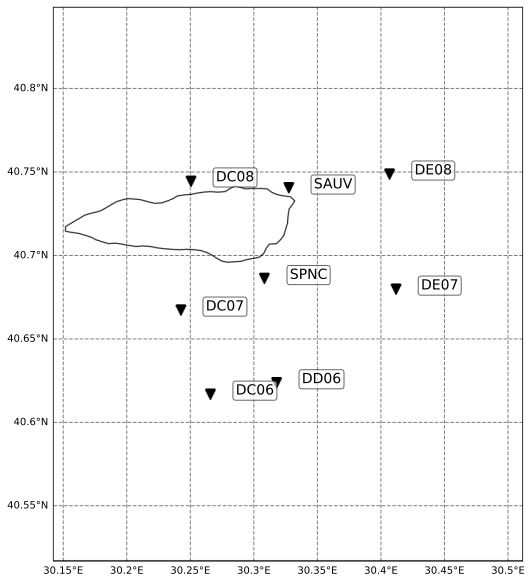

In [12]:
%config InlineBackend.figure_formats = ["svg"]

# plot a simple map with the station locations
fig = net.plot_map()